In [5]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import jaccard_score
import random

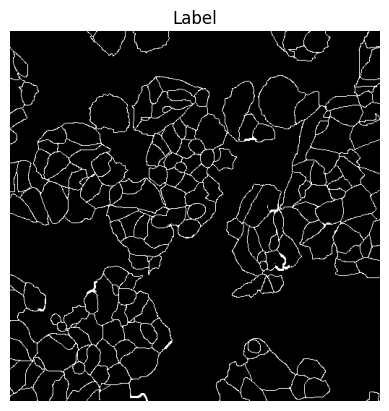

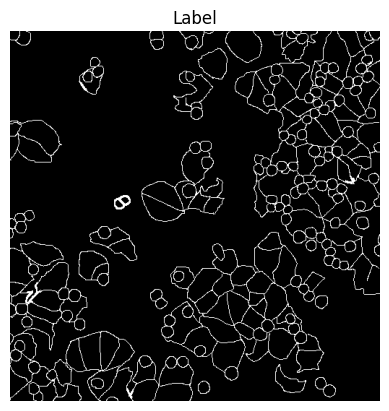

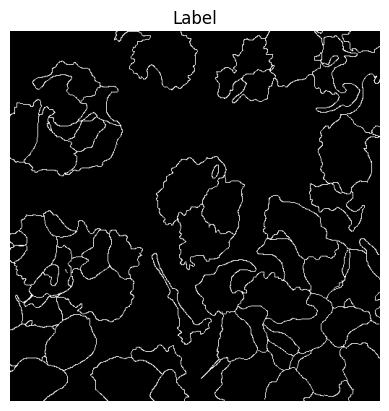

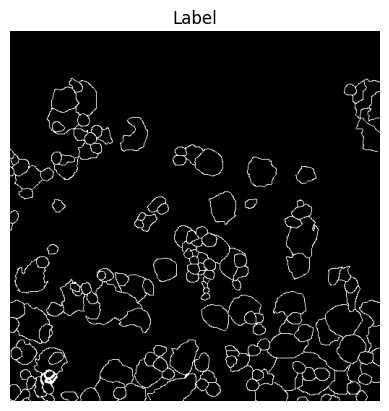

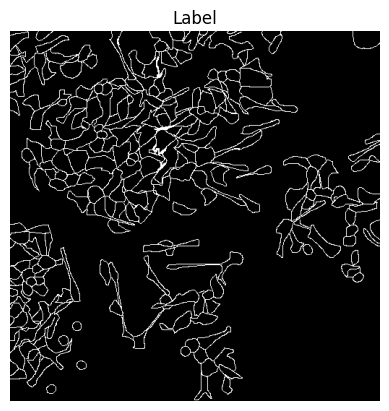

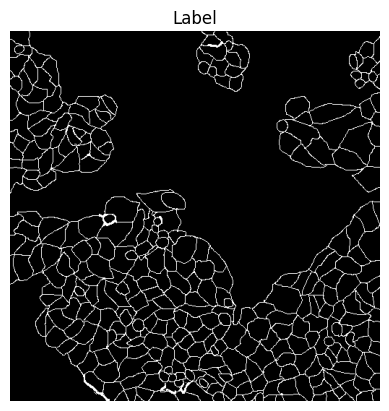

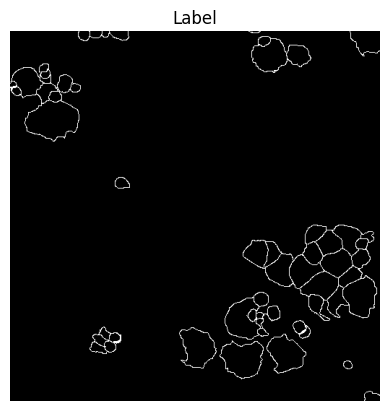

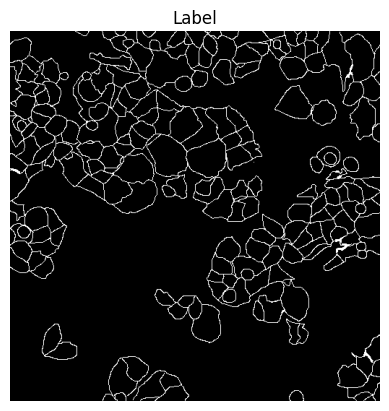

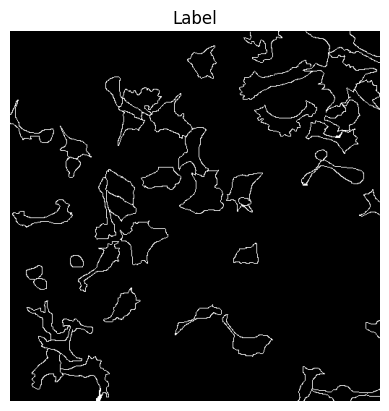

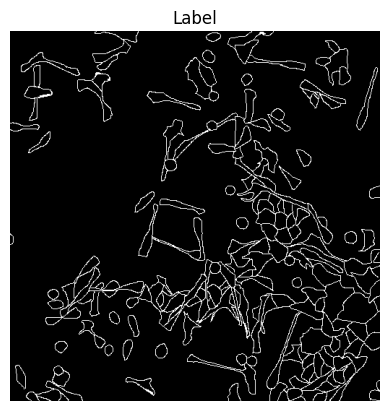

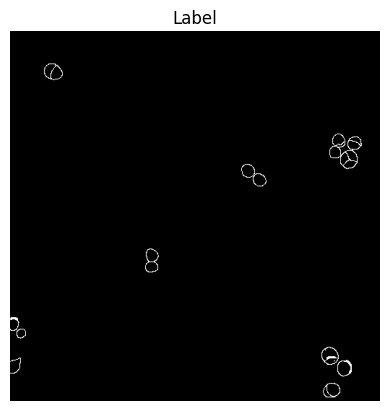

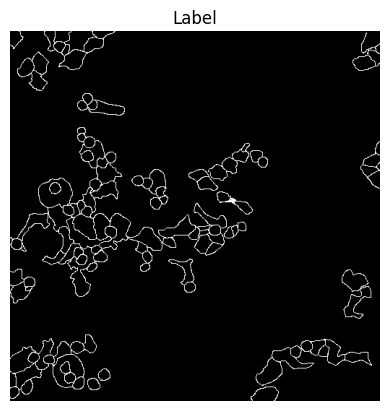

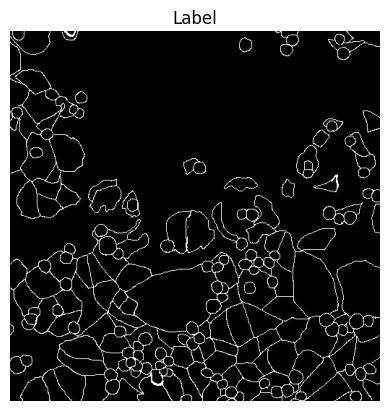

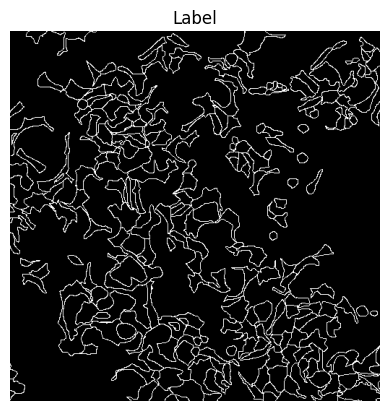

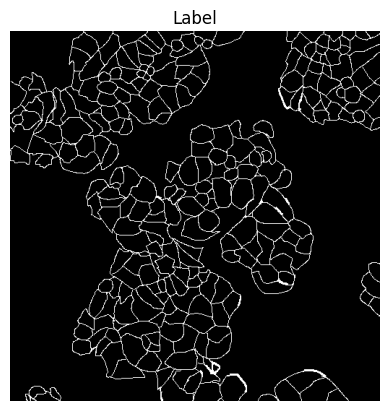

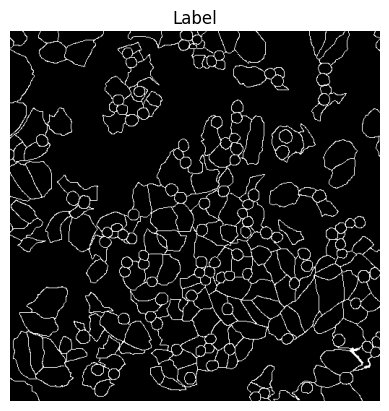

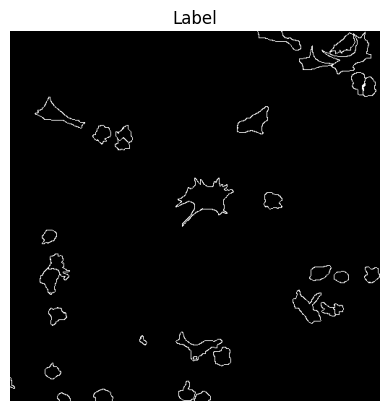

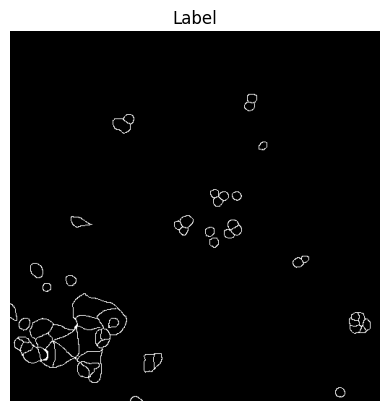

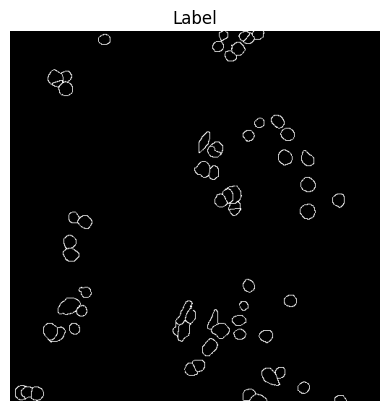

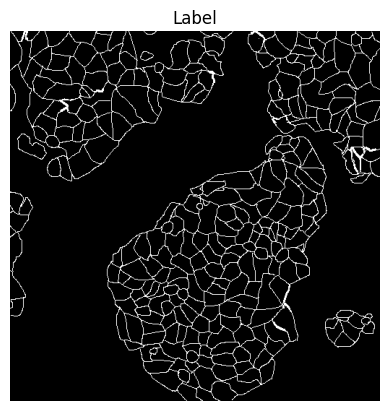

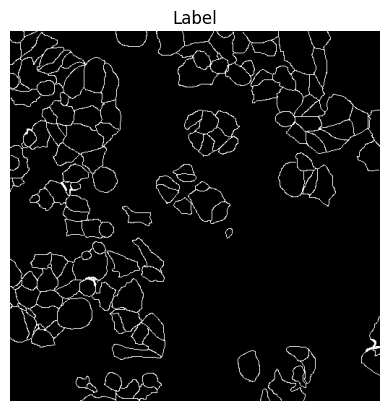

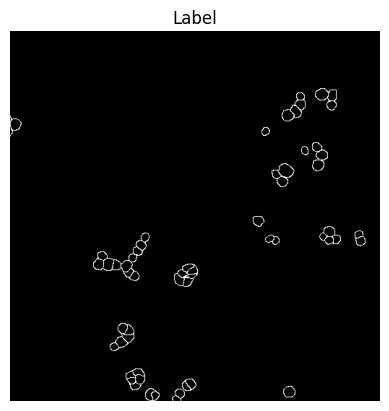

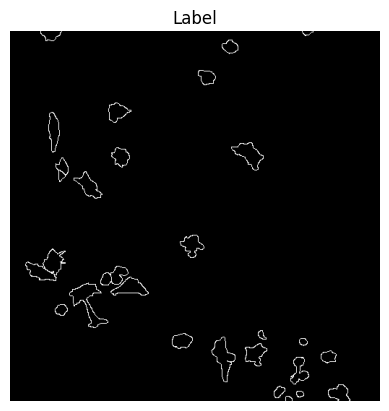

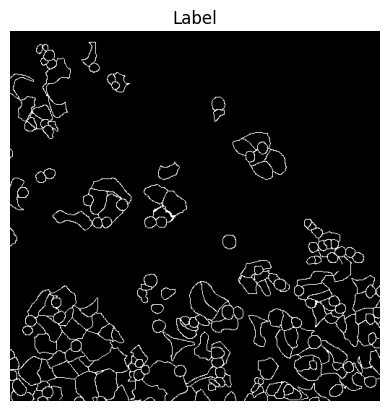

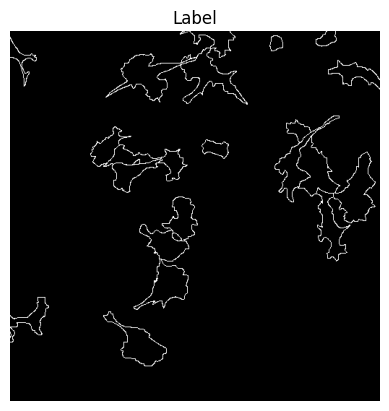

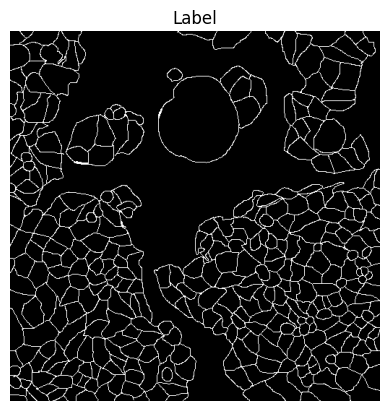

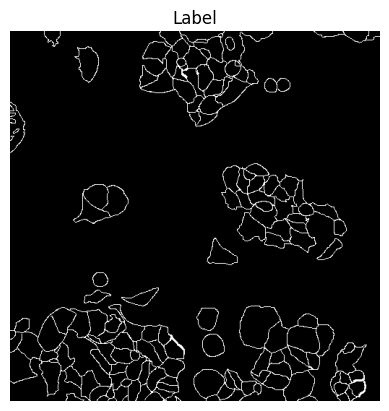

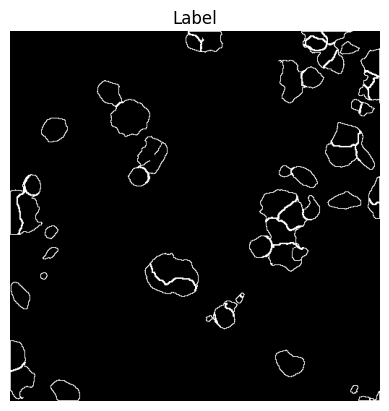

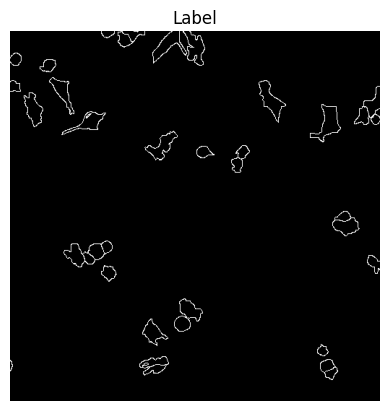

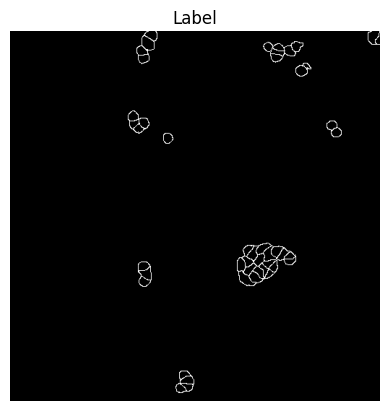

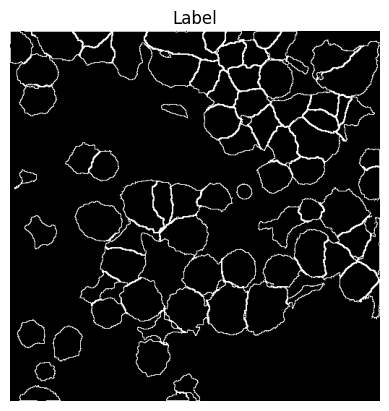

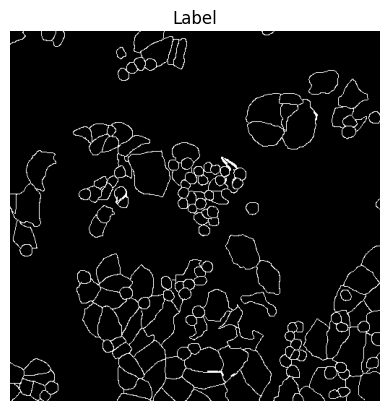

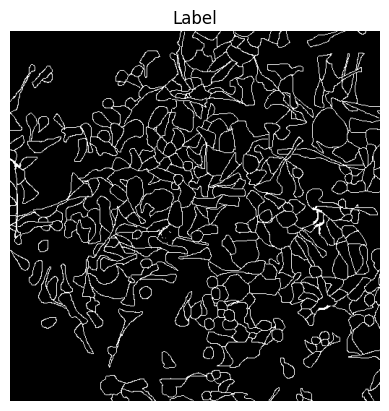

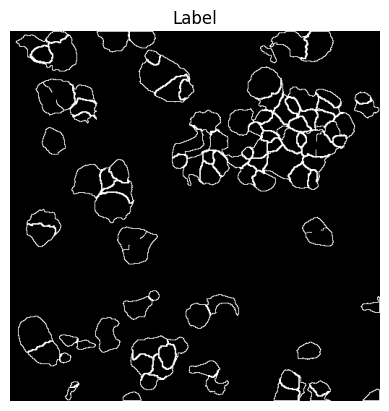

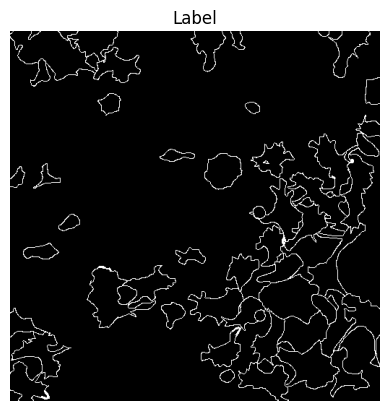

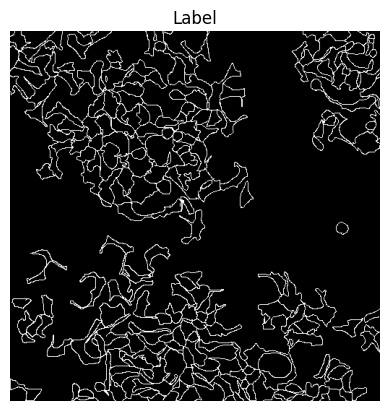

In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = [f for f in os.listdir(data_dir) if f.endswith('.png') and '_outline' not in f]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.data_dir, img_name)
        label_name = img_name.replace('.png', '_outline.png')
        label_path = os.path.join(self.data_dir, label_name)

        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path).convert('L')

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

class ToTensorAndNormalize:
    def __call__(self, image):
        image = transforms.functional.to_tensor(image)
        if image.size(0) == 1:                    # 标签，确保单通道图片转换后的size匹配期望值，为1
            image = image.squeeze(0).long()       # 转换为长整数类型
        return image

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    ToTensorAndNormalize()
])

train_dataset = SegmentationDataset('C:/Users/lcf14/Desktop/dataset/train', transform=transform)
val_dataset = SegmentationDataset('C:/Users/lcf14/Desktop/dataset/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)


# 遍历train_loader
for images, labels in train_loader:
    # 显示images
    '''for image in images:
        image_np = image.permute(1, 2, 0).numpy()  # 将Tensor转换为NumPy数组，并将通道维度放在最后
        plt.figure()
        plt.imshow(image_np)
        plt.axis('off')
        plt.title('Image')
        plt.show()'''

    # 显示labels
    for label in labels:
        label_np = label.squeeze().numpy()  # 将Tensor转换为NumPy数组
        plt.figure()
        plt.imshow(label_np, cmap='gray')
        plt.axis('off')
        plt.title('Label')
        plt.show()

In [118]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class UNetResNet34(nn.Module):
    def __init__(self, n_classes):
        super(UNetResNet34, self).__init__()
        base_model = models.resnet34(pretrained=True)
        self.base_layers = list(base_model.children())

        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[3:5])
        self.encoder2 = self.base_layers[5]
        self.encoder3 = self.base_layers[6]
        self.encoder4 = self.base_layers[7]

        self.center = self.conv_block(512, 512)

        self.decoder4 = self.up_conv(512, 256)
        self.decoder3 = self.up_conv(256 + 256, 128)
        self.decoder2 = self.up_conv(128 + 128, 64)
        self.decoder1 = self.up_conv(64 + 64, 64)
        self.decoder0 = self.up_conv(64 + 64, 32)

        self.final_conv = nn.Conv2d(32, n_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def up_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc0 = self.encoder0(x)
        enc1 = self.encoder1(enc0)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)

        center = self.center(enc4)

        dec4 = self.decoder4(center)
        dec4 = torch.cat([dec4, enc3], dim=1)
        dec3 = self.decoder3(dec4)
        dec3 = torch.cat([dec3, enc2], dim=1)
        dec2 = self.decoder2(dec3)
        dec2 = torch.cat([dec2, enc1], dim=1)
        dec1 = self.decoder1(dec2)
        dec1 = torch.cat([dec1, enc0], dim=1)
        dec0 = self.decoder0(dec1)
        dec0 = self.final_conv(dec0)
        return torch.sigmoid(dec0)

model = UNetResNet34(n_classes=1).cuda()
print(model)

UNetResNet34(
  (encoder0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder1): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

In [119]:
# Dice Loss
class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1e-6):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

# IOU
def iou_loss(inputs, targets):
    inputs = inputs.float()
    targets = targets.float()
    intersection = (inputs * targets).sum((1, 2, 3))
    union = (inputs + targets).sum((1, 2, 3)) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [120]:
# 训练和验证
num_epochs = 300
train_loss_history = []
val_loss_history = []
train_iou_history = []
val_iou_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_iou = 0.0
    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_iou += iou_loss(outputs, labels)

    train_loss /= len(train_loader.dataset)
    train_iou /= len(train_loader)
    train_loss_history.append(train_loss)
    train_iou_history.append(train_iou)

    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels.float())

            val_loss += loss.item() * images.size(0)
            val_iou += iou_loss(outputs, labels)

    val_loss /= len(val_loader.dataset)
    val_iou /= len(val_loader)
    val_loss_history.append(val_loss)
    val_iou_history.append(val_iou)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train IOU: {train_iou:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val IOU: {val_iou:.4f}')


# 保存模型
torch.save(model.state_dict(), 'UNetResNet34.pth')

Epoch 1/300:
Train Loss: 0.9152, Train IOU: 0.0432
Val Loss: 0.8973, Val IOU: 0.0538
Epoch 2/300:
Train Loss: 0.9031, Train IOU: 0.0459
Val Loss: 0.8832, Val IOU: 0.0574
Epoch 3/300:
Train Loss: 0.8928, Train IOU: 0.0484
Val Loss: 0.8654, Val IOU: 0.0616
Epoch 4/300:
Train Loss: 0.8820, Train IOU: 0.0509
Val Loss: 0.8542, Val IOU: 0.0641
Epoch 5/300:
Train Loss: 0.8779, Train IOU: 0.0526
Val Loss: 0.8461, Val IOU: 0.0661
Epoch 6/300:
Train Loss: 0.8713, Train IOU: 0.0539
Val Loss: 0.8411, Val IOU: 0.0671
Epoch 7/300:
Train Loss: 0.8680, Train IOU: 0.0548
Val Loss: 0.8338, Val IOU: 0.0691
Epoch 8/300:
Train Loss: 0.8628, Train IOU: 0.0560
Val Loss: 0.8313, Val IOU: 0.0698
Epoch 9/300:
Train Loss: 0.8602, Train IOU: 0.0567
Val Loss: 0.8291, Val IOU: 0.0702
Epoch 10/300:
Train Loss: 0.8575, Train IOU: 0.0575
Val Loss: 0.8245, Val IOU: 0.0717
Epoch 11/300:
Train Loss: 0.8569, Train IOU: 0.0582
Val Loss: 0.8234, Val IOU: 0.0718
Epoch 12/300:
Train Loss: 0.8501, Train IOU: 0.0591
Val Loss: 0

In [121]:
def evaluate_model(path: str, model: 'UNetResNet34') -> tuple[float, float]:
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        ToTensorAndNormalize()
    ])
    dataset = SegmentationDataset(path, transform=transform)
    loader = DataLoader(dataset, batch_size=2, shuffle=False)
    
    model.eval()
    dice_loss_sum = 0.0
    iou_sum = 0.0
    criterion = DiceLoss()
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            dice_loss_sum += criterion(outputs, labels.float()).item() * images.size(0)
            iou_sum += iou_loss(outputs, labels)
    
    Dice_Loss = dice_loss_sum / len(loader.dataset)
    IOU = iou_sum / len(loader)
    
    return Dice_Loss, IOU


model.load_state_dict(torch.load('UNetResNet34.pth'))
train_dice_loss, train_iou = evaluate_model('C:/Users/lcf14/Desktop/dataset/train', model)
val_dice_loss, val_iou = evaluate_model('C:/Users/lcf14/Desktop/dataset/val', model)
print(f'Train Dice Loss: {train_dice_loss:.4f}, Train IOU: {train_iou:.4f}')
print(f'Val Dice Loss: {val_dice_loss:.4f}, Val IOU: {val_iou:.4f}')

Train Dice Loss: 0.0661, Train IOU: 0.3036
Val Dice Loss: 0.7219, Val IOU: 0.0822


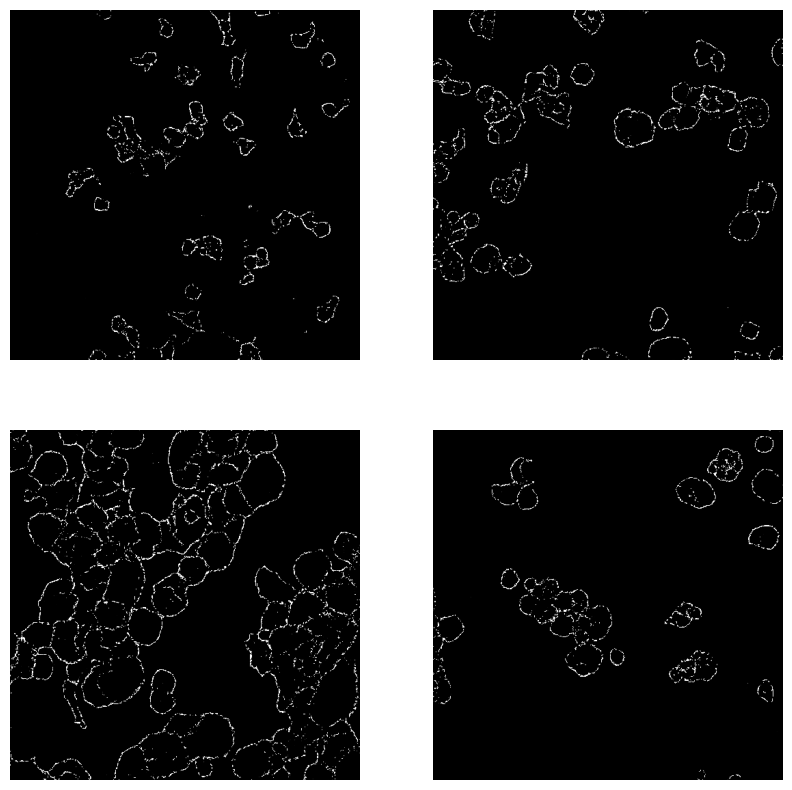

In [122]:
def plot_predictions(path: str, model: 'UNetResNet34', nrows: int = 2, ncols: int = 2):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        ToTensorAndNormalize()
    ])
    dataset = SegmentationDataset(path, transform=transform)
    indices = random.sample(range(len(dataset)), nrows * ncols)
    samples = [dataset[idx] for idx in indices]
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))
    
    model.eval()
    with torch.no_grad():
        for idx, (image, label) in enumerate(samples):
            img_input = image.unsqueeze(0).cuda()
            pred = model(img_input).cpu().squeeze().numpy()
            image = image.permute(1, 2, 0).numpy()
            label = label.numpy()
            
            ax = axs[idx // ncols, idx % ncols]
            ax.imshow(image, cmap='gray')
            ax.imshow(label, cmap=plt.cm.gray, alpha=1)
            ax.imshow(pred, cmap=plt.cm.gray, alpha=1)
            ax.axis('off')
    plt.show()

plot_predictions('C:/Users/lcf14/Desktop/dataset/val', model, nrows=2, ncols=2)